In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy.interpolate import interp1d

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
import scipy.io
mat = scipy.io.loadmat('data/stim4.mat')

In [4]:
def extract(tree):
    for x in range(len(tree)):
        if type(tree[x]) == list:
            tree[x] = extract(tree[x])
        else:
            return tree[x]

    return tree

In [5]:
len(mat['stim'][0][0]) #11


11

In [6]:
mat['stim'][0][0][0] # stimulus details
mat['stim'][0][0][1] # listening dates and times
mat['stim'][0][0][2] # time
mat['stim'][0][0][3] # corrugator sEMG
mat['stim'][0][0][4] # zygomaticus sEMG
mat['stim'][0][0][5] # trapezius sEMG
mat['stim'][0][0][6] # BVP
mat['stim'][0][0][7] # SCR
mat['stim'][0][0][8] # temp
mat['stim'][0][0][9] # Resp
mat['stim'][0][0][10] # Ratings
stim = mat['stim'][0][0]
arrayRef =[stim[1][0][0][0][0][1].dtype,stim[1][0][0][0][0][15].dtype]
print(stim[0])
print(stim[0][0][0][1][0])

Levels =(['track', 'sess', 'time', 'emgc', 'emgz', 'emgt', 'bvp', 'scon', 'temp', 'resp', 'beh'])
Level = [['piece', 'album', 'performer', 'composer', 'genre', 'stimN', 'duration']]
Level.append(['date', 'timeD', 'timeS', 'order', 'prev', 'notes', 'sneezes'])
Level.append(['s', 'sT', 'Hz'])
Level.append(['raw', 'filt', 'filtN', 'rms', 'rmsN'])
Level.append(['raw', 'filt', 'filtN', 'rms', 'rmsN'])
Level.append(['raw', 'filt', 'filtN', 'rms', 'rmsN'])
Level.append(['raw', 'filt', 'filtN', 'bpm', 'amp', 'beat'])
Level.append(['raw', 'filt', 'filtN', 'tonic', 'tonicN', 'ORt'])
Level.append(['raw', 'rawN', 'filt', 'filtN'])
Level.append(['raw', 'rawN', 'filt', 'filtN', 'bpm', 'phase', 'Inha'])
Level.append(['aro', 'val'])

LevelResponse = ['D', 'T', 'R', 'N']
Level

[[(array(['The Littlest Birds'], dtype='<U18'), array(['Blue Horse'], dtype='<U10'), array(['The Be Good Tanyas'], dtype='<U18'), array(['The Be Good Tanyas'], dtype='<U18'), array(['Folk'], dtype='<U4'), array([[4]], dtype=uint8), array([[246]], dtype=uint8))]]
Blue Horse


[['piece', 'album', 'performer', 'composer', 'genre', 'stimN', 'duration'],
 ['date', 'timeD', 'timeS', 'order', 'prev', 'notes', 'sneezes'],
 ['s', 'sT', 'Hz'],
 ['raw', 'filt', 'filtN', 'rms', 'rmsN'],
 ['raw', 'filt', 'filtN', 'rms', 'rmsN'],
 ['raw', 'filt', 'filtN', 'rms', 'rmsN'],
 ['raw', 'filt', 'filtN', 'bpm', 'amp', 'beat'],
 ['raw', 'filt', 'filtN', 'tonic', 'tonicN', 'ORt'],
 ['raw', 'rawN', 'filt', 'filtN'],
 ['raw', 'rawN', 'filt', 'filtN', 'bpm', 'phase', 'Inha'],
 ['aro', 'val']]

In [7]:
SRP ={}

md = 0
bit = {}
structNames = Level[md] 
for i in range(len(structNames)):
    det =stim[0][0][md][i].ravel()[0] #extract(stim[0][0][md][i])
    
    bit[structNames[i]] = det
SRP[Levels[md]]=bit

md +=1
bit = {}
structNames = Level[md] 
for i in range(len(structNames)):
    det =  stim[md][0][0][i].ravel()
    if len(det)==24:
        days = []
        for j in range(24):
            if str(det[j].dtype).startswith('<U'):
                if len(extract([det[j]]))>0:
                    days.append(extract(det[j]))
                else:
                    days.append([])
            else:
                if str(det[j].dtype).startswith('u'):
                    if det[j].shape == (0,0):
                        days.append('')
                    else:
                        days.append(det[j])
                    
                else:
                    days.append(det[j])
        det = days
    bit[structNames[i]] = det
SRP[Levels[md]]=bit    

md +=1
bit = {}
structNames = Level[md] 
for i in range(len(structNames)):
    det =stim[md][0][0][i].ravel()
    if len(det)==1:
        det = det[0]
    bit[structNames[i]] = det
SRP[Levels[md]]=bit
SRP['time']['s'] = np.round(SRP['time']['s'],2)

for md in range(3,11):
    bit = {}
    structNames = Level[md] 
    for i in range(len(structNames)):
        det =  stim[md][0][0][i].ravel()[0]
        if len(det)==4:
            signals = {LevelResponse[0]:pd.DataFrame(data=det[0],index=SRP['time']['s']),
                      LevelResponse[1]:det[1][0],
                      LevelResponse[2]:det[2][0][0],
                      LevelResponse[3]:det[3][0]}
            bit[structNames[i]] = signals
    SRP[Levels[md]]=bit  


In [8]:
SRP.keys()

dict_keys(['track', 'sess', 'time', 'emgc', 'emgz', 'emgt', 'bvp', 'scon', 'temp', 'resp', 'beh'])

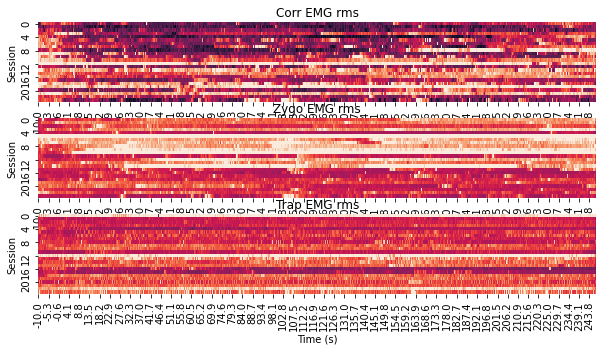

In [9]:
bio = SRP['emgc']['rms']
kstep = 10
substep = np.arange(0,len(bio['D']),kstep)
Np = 24

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(311)
bio = SRP['emgc']['rms']
bio['D']
sns.heatmap(bio['D'].iloc[substep].transpose(),ax=ax,cbar=False, vmin=0, vmax=4)#, cmap="YlGnBu")
plt.title(bio['T'])
plt.ylabel('Session')

ax = fig.add_subplot(312)
bio = SRP['emgz']['rms']
sns.heatmap(bio['D'].iloc[substep].transpose(),ax=ax,cbar=False,vmin=0, vmax=4)#, cmap="YlGnBu")
plt.title(bio['T'])
plt.ylabel('Session')

ax = fig.add_subplot(313)
bio = SRP['emgt']['rms']
sns.heatmap(bio['D'].iloc[substep].transpose(),ax=ax,cbar=False,vmin=0, vmax=8)#, cmap="YlGnBu")
plt.title(bio['T'])
plt.ylabel('Session')
plt.xlabel('Time (s)')
plt.show()


<AxesSubplot:>

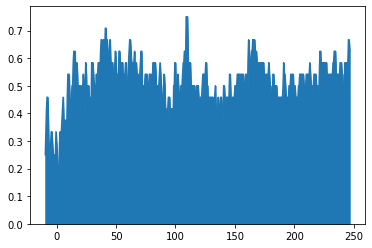

In [14]:
actType='UBound'
Thresh = 3
AC = activityCount(Data,FrameSize,HopSize,Thresh,actType)
AC['Total'].plot.area()

<AxesSubplot:>

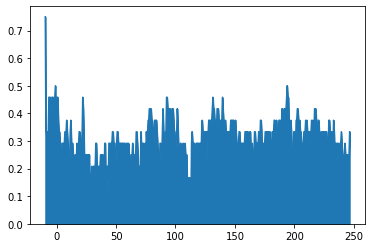

In [15]:
actType='LBound'
Thresh = 2
AC = aa.activityCount(Data,FrameSize,HopSize,Thresh,actType)
AC['Total'].plot.area()

In [348]:
AC

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Total
-9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
Data = SRP['emgz']['rms']['D']
FrameSize = 1 # second
HopSize = 0.5 # seconds
Thresh = 4

Time = Data.index
cols = Data.columns
newTime = np.arange(FrameSize/2+Time[0],Time[-1],HopSize)
Acts = pd.DataFrame(columns = cols)
# ""Acts['Time']=newTime
# Acts=Acts.set_index('Time')""

tic = time.time()
for i in range(len(newTime)):
        t = newTime[i]
        frame = Data.loc[t-(FrameSize*0.5):t+(FrameSize*0.5),:].copy()
        UB = frame.max(0)
        UB[UB>=Thresh] = Thresh
        UB[UB<Thresh] = 0
        UB[UB==Thresh] = 1
        df2 = pd.DataFrame(columns = cols)
        df2.loc[t] = UB
        Acts =Acts.append(df2)
print(time.time()-tic)
    
Acts

3.066977024078369


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
-9.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
-9.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
-8.5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
-8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.5,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244.5,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
245.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245.5,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# function file for activity analysis 

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import binom, poisson, chisquare,chi2

def activityCount(Data,FrameSize,HopSize,Thresh,actType):
    ''' def activityCount(Data,FrameSize,HopSize,Thresh,actType)
    (Time,Series,FrameSize,HopSize,Thresh,option)

     function to identify the occurances and popularity of activity 
     events (specified by 'option' and 'Thresh') across the columns
     of Data time series over frames of size FrameSize and 
     intervals of Hopsize. Columns are treated as signals to be 
     translated into point processes.
     
     Inputs: Data - an pandas dataframe with index of time in the same units
                    as FrameSize and Hopsize and columns of signal measurements
             FrameSize - the interval of signal actions are to be evaluated over
             HopSize - the spacing between these intervals of signal (can be smaller than FrameSize)
             Thresh - a minimum value (scalar) for events measured in frames
             actType - a string specifying the type of signal event to detect
                     one of {'Inc','Dec','Change','UBound','LBound'} (so far)
     Outputs: Acts - a pandas dataframe with index 'Time' of time points (centres of frames)
                     columns for every column of signal in Data (carries names)
                     final column ['Total'] that reports the ratio of signals active per frame
     Version 5.0, first in Python 3
     Finn Upham 2020 12 07
     '''

    Time = Data.index
    cols = Data.columns
    
    newTime = np.arange(FrameSize/2+Time[0],Time[-1],HopSize)
    Acts = pd.DataFrame(columns = cols)


    # for increases
    if actType == 'Inc':
        Acts['Time']=newTime
        Acts=Acts.set_index('Time')
        for col in cols:
            f = interp1d(Time,Data[col], kind='nearest',fill_value='extrapolate')
            a=f(newTime+FrameSize/2)-f(newTime-FrameSize/2)
            a[a>=Thresh] = 1
            a[a<Thresh] = 0
            Acts[col]=a
    if actType == 'Dec':
        Acts['Time']=newTime
        Acts=Acts.set_index('Time')
        for col in cols:
            f = interp1d(Time,Data[col], kind='nearest',fill_value='extrapolate')
            a=f(newTime+FrameSize/2)-f(newTime-FrameSize/2)
            a[a>-Thresh] = 0
            a[a<=-Thresh] = 1
            Acts[col]=a 
    if actType == 'Change':
        Acts['Time']=newTime
        Acts=Acts.set_index('Time')
        for col in cols:
            f = interp1d(Time,Data[col], kind='nearest',fill_value='extrapolate')
            a=np.abs(f(newTime+FrameSize/2)-f(newTime-FrameSize/2))
            a[a>=Thresh] = 1
            a[a<Thresh] = 0
            Acts[col]=a  
            
    if actType == 'UBound':
        # prime the Acts dataframe to have teh same columns as Data
        # interate over rows of 
        for i in range(len(newTime)):
            t = newTime[i]
            frame = Data.loc[t-(FrameSize*0.5):t+(FrameSize*0.5),:]
            UB = frame.max(0)
            UB[UB>=Thresh] = Thresh
            UB[UB<Thresh] = 0
            UB[UB==Thresh] = 1
            df2 = pd.DataFrame(columns = cols)
            df2.loc[t] = UB
            Acts =Acts.append(df2)
    
    if actType == 'LBound':
        # prime the Acts dataframe to have teh same columns as Data
        # interate over rows of 
        for i in range(len(newTime)):
            t = newTime[i]
            frame = Data.loc[t-(FrameSize*0.5):t+(FrameSize*0.5),:]
            UB = frame.min(0)
            UB[UB<=Thresh] = Thresh
            UB[UB>Thresh] = 0
            UB[UB==Thresh] = 1
            df2 = pd.DataFrame(columns = cols)
            df2.loc[t] = UB
            Acts =Acts.append(df2)

    Acts['Total'] = Acts.sum(1)/len(cols) # ratio of signals active per frame
    return Acts
